# Отчёт по центру обращений

In [1]:
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sn
import warnings

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## Вспомогательные переменные

In [3]:
# Сегодняшний день
today = datetime.date.today()
# Сегодняшний день недели
today_weekday = today.strftime('%A')
# Сейчас
now_row = datetime.datetime.now()
now = now_row.strftime("%Y-%m-%d %H-%M-%S")
# Вчерашняя дата, позавчерашняя и т.д.
yesterday = today - datetime.timedelta(days=1)
the_day_before_yeasterday = today - datetime.timedelta(days=2)
two_days_before_yeasterday = today - datetime.timedelta(days=3)
three_days_before_yeasterday = today - datetime.timedelta(days=4)
four_days_before = today - datetime.timedelta(days=5)
five_days_before = today - datetime.timedelta(days=6)
# Список логистических центров
LC = ['Воронеж','Казань','Котельники','МЯ','Новосибирск','Ростов','Самара','СЗ', 'Урал','ЦПП']
# путь в директорию архива
# для рекламаций
archive_path_not_ready =f"C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\Архив\\{now} Не закрытые товарные.xlsx"
# для обращений
archive_path_not_ready_non_marketable = f"C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\Архив\\{now} Качество обслуживания.xlsx"


##  Загрузка данных

In [4]:
# загрузка построчного файла рекламаций
raw_compliants_lines = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\yyy.csv",
                                   encoding='utf-8', dtype={'Описание претензии': str}, low_memory=False, sep=';')
# загрузка файла рекламаций
raw_compliants = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\xxx.csv",
                             encoding='utf-8', dtype={'Описание претензии': str}, sep=';')
# загрузка файла с нетоварными обращениями
raw_non_marketable = pd.read_csv("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\zzz.csv",
                             encoding='utf-8', dtype={'Описание претензии': str}, sep=';')

# Чтение и загрузка ВПР, создание слоарей из файлов
# списки принадлежности ВТЦ и ОП к логистическим центрам
VPR_compliants_lines_lc = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР построчный ЛЦ.xlsx")
key_compliants_lines_lc = dict(zip(VPR_compliants_lines_lc['Текст'], VPR_compliants_lines_lc['Значение']))
# ЛЦ для нетоварных
VPR_non_marketable = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР нетоварные ЛЦ.xlsx")
key_non_marketable = dict(zip(VPR_non_marketable['Текст'], VPR_non_marketable['Значение']))
# Маркер этапа для построчных рекламаций
VPR_compliants_lines_stage_marker = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР построчный маркер этапа.xlsx")
key_compliants_lines_stage_marker = dict(zip(VPR_compliants_lines_stage_marker['Текст'],
                                            VPR_compliants_lines_stage_marker['Значение']))
# Маркер этапа для рекламаций
VPR_compliants_stage_marker = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР рабочий маркер этапа.xlsx")
key_compliants_stage_marker = dict(zip(VPR_compliants_stage_marker['Текст'],
                                            VPR_compliants_stage_marker['Значение']))
# Таймер контроля для незавершенных рекламаций
VPR_control_timer = pd.read_excel("C:\\Users\\rassadin_mi\\Desktop\\автоматизация отчёт ЦО\\отчёт по ЦО\\ВПР\\ВПР таймер контроля.xlsx")
key_control_timer = dict(zip(VPR_control_timer['Текст'],
                                            VPR_control_timer['Значение']))

## Предобработка форматов данных

In [5]:
# Преобразование форматов времени
raw_compliants[['Дата запуска процесса', 
                'Дата завершения процесса']] = raw_compliants[[
                'Дата запуска процесса', 
                'Дата завершения процесса']].apply(pd.to_datetime)
raw_compliants['Дата запуска текущего этапа'] = pd.to_datetime(
    raw_compliants['Дата запуска текущего этапа'], format='%d.%m.%Y %H:%M:%S')

raw_compliants_lines[['Дата запуска процесса',
                      'Дата завершения процесса']] = raw_compliants_lines[[
                      'Дата запуска процесса',
                      'Дата завершения процесса']].apply(pd.to_datetime)
raw_compliants_lines['Дата запуска текущего этапа'] = pd.to_datetime(
    raw_compliants_lines['Дата запуска текущего этапа'], format='%d.%m.%Y %H:%M:%S')

In [6]:
raw_non_marketable[['Дата запуска','Дата ответа',
                    'Дата запуска текущего этапа',
                    'Дата закрытия текущего этапа']] = raw_non_marketable[[
                    'Дата запуска','Дата ответа',
                    'Дата запуска текущего этапа',
                    'Дата закрытия текущего этапа']].apply(lambda x: pd.to_datetime(x, format='%d.%m.%Y %H:%M:%S'))

## Работа с построчным файлом рекламаций

In [7]:
compliants_lines = raw_compliants_lines

In [8]:
# Функция для идентификации города ЛЦ по должности менеджера
def get_lc(row):
    if row['Должность менеджера из документа'] in key_compliants_lines_lc:
        return key_compliants_lines_lc[row['Должность менеджера из документа']]
    elif row['РК по документу'] in key_compliants_lines_lc:
        return key_compliants_lines_lc[row['РК по документу']]
    else:
        return None
compliants_lines['ЛЦ'] = compliants_lines.apply(get_lc, axis=1)

# Установка маркера для этапов
def get_stage_marker(row):
    if row['Текущий этап'] in key_compliants_lines_stage_marker:
        return key_compliants_lines_stage_marker[row['Текущий этап']]
    else:
        return None
compliants_lines['Маркер этапа'] = compliants_lines.apply(get_stage_marker, axis=1)

In [9]:
# Первая вкладка чистая с "ЛЦ" и "Маркер этапа" без столбцов прописанных в коде ниже и с правильным порядком столбцов
compliants_lines_pure = compliants_lines.drop(['Кол-во товара', 'Id процесса',
                                          'Уход','Результат возврата/обмена/довоза',
                                          'Ожидает ответа поставщика','ФИО сотр. допуст. ошибку',
                                          'Должн. сотр. допуст. ошибку','Описание ошибки',
                                               'Кто определил допуст. ошибку'], axis=1)
compliants_lines_pure = compliants_lines_pure.rename(columns={'Id родительского процесса': 'Id процесса'})
compliants_lines_columns_order = ['Id процесса','РК по документу','ОП по складу',
                                  'Номер документа','Код к/а','Название к/а','ФИО к/а','Телефон к/а','Класс 71',
                                  'Класс 72','Менеджер из документа','Должность менеджера из документа','ЛЦ','Класс 55',
                                  'РК исполнителя этапа','Должность исполнителя этапа','Описание претензии','Описание',
                                  'Комментарий','Производитель','Код производителя','Код товара','Описание товара',
                                  'Класс 33','Цена за ед. измерения без НДС','Исполнитель текущего этапа','Текущий этап',
                                  'Решение','Дата запуска процесса','Дата завершения процесса',
                                  'Количество дней работы процесса','Дата запуска текущего этапа',
                                  'Количество часов отработки этапа процесса', 'Маркер этапа']
compliants_lines_pure = compliants_lines_pure.reindex(columns=compliants_lines_columns_order)

In [10]:
# Это готовый построчный файл который мы будем сливать с рабочим, его отличие от compliants_lines_pure -
# лишние удалённые столбцы которые прописаны в коде ниже
compliants_lines_ready = compliants_lines_pure.drop(['Решение','Описание','Комментарий','Производитель',
                                                'Код производителя','Код товара','Описание товара',
                                                'Класс 33','Цена за ед. измерения без НДС'], axis=1)

## Работа с файлом рекламаций

In [11]:
# Добавляю столбец с городом ЛЦ
raw_compliants['ЛЦ'] = raw_compliants.apply(get_lc, axis=1)

# Добавляю маркер этапа
def get_stage_marker2(row):
    if row['Текущий этап'] in key_compliants_stage_marker:
        return key_compliants_stage_marker[row['Текущий этап']]
    else:
        return None
raw_compliants['Маркер этапа'] = raw_compliants.apply(get_stage_marker2, axis=1)

compliants_pure = raw_compliants.drop(['Результат Возврата Товара',
                                          'Результат Замены Довоза'], axis=1)

In [12]:
compliants = raw_compliants.drop(['Результат Возврата Товара',
                                          'Результат Замены Довоза'], axis=1)

In [13]:
compliants_created_ended = compliants
compliants_created_ended.drop_duplicates(subset='Id процесса', keep='first', inplace=True)

In [14]:
# Кусок кода на случай если сегодня понедельник. Он выведет все рекламации за пятницу и субботу.
# Да это некрасиво, но пока нет времени оптимизировать данный участок

if today_weekday == 'Monday':
    compliants_created_ended["Дата запуска процесса"] = pd.to_datetime(compliants_created_ended["Дата запуска процесса"]).dt.date
    compliants_created_ended["Дата завершения процесса"] = pd.to_datetime(compliants_created_ended["Дата завершения процесса"]).dt.date
    # Фильтруем DataFrame по условию равенства с вчерашней датой
    compliants_created_ended_yesterday = compliants_created_ended[compliants_created_ended["Дата запуска процесса"] == two_days_before_yeasterday ]
    compliants_created_started_yesterday = compliants_created_ended[compliants_created_ended["Дата завершения процесса"] == two_days_before_yeasterday ]
    count_created = compliants_created_ended_yesterday.groupby("ЛЦ").agg(
    {'Дата запуска процесса': 'count'}).reset_index()
    count_closed = compliants_created_started_yesterday.groupby("ЛЦ").agg(
    {'Дата завершения процесса': 'count'}).reset_index()
    created_closed_yesterday = pd.merge(count_created, count_closed, on='ЛЦ', how='outer')
    created_closed_yesterday = created_closed_yesterday.rename(columns={'Дата запуска процесса': f'Запущено обращений {two_days_before_yeasterday}',
                                         'Дата завершения процесса': f'Закрыто обращений {two_days_before_yeasterday}'})
    created_closed_yesterday.set_index('ЛЦ', inplace=True)
    print(created_closed_yesterday)
if today_weekday == 'Monday':
    compliants_created_ended["Дата запуска процесса"] = pd.to_datetime(compliants_created_ended["Дата запуска процесса"]).dt.date
    compliants_created_ended["Дата завершения процесса"] = pd.to_datetime(compliants_created_ended["Дата завершения процесса"]).dt.date
    compliants_created_ended_yesterday = compliants_created_ended[compliants_created_ended["Дата запуска процесса"] ==the_day_before_yeasterday ]
    compliants_created_started_yesterday = compliants_created_ended[compliants_created_ended["Дата завершения процесса"] == the_day_before_yeasterday ]
    count_created = compliants_created_ended_yesterday.groupby("ЛЦ").agg(
    {'Дата запуска процесса': 'count'}).reset_index()
    count_closed = compliants_created_started_yesterday.groupby("ЛЦ").agg(
    {'Дата завершения процесса': 'count'}).reset_index()
    created_closed_yesterday = pd.merge(count_created, count_closed, on='ЛЦ', how='outer')
    created_closed_yesterday = created_closed_yesterday.rename(columns={'Дата запуска процесса': f'Запущено обращений {the_day_before_yeasterday}',
                                         'Дата завершения процесса': f'Закрыто обращений {the_day_before_yeasterday}'})
    created_closed_yesterday.set_index('ЛЦ', inplace=True)
    print(created_closed_yesterday)    

In [15]:
# Преобразуем столбец "Дата запуска процесса" в формат даты
compliants_created_ended["Дата запуска процесса"] = pd.to_datetime(compliants_created_ended["Дата запуска процесса"]).dt.date
compliants_created_ended["Дата завершения процесса"] = pd.to_datetime(compliants_created_ended["Дата завершения процесса"]).dt.date
# Фильтруем DataFrame по условию равенства с вчерашней датой
compliants_created_ended_yesterday = compliants_created_ended[compliants_created_ended["Дата запуска процесса"] == yesterday ]
compliants_created_started_yesterday = compliants_created_ended[compliants_created_ended["Дата завершения процесса"] == yesterday ]


In [16]:
count_created = compliants_created_ended_yesterday.groupby("ЛЦ").agg(
    {'Дата запуска процесса': 'count'}).reset_index()
count_closed = compliants_created_started_yesterday.groupby("ЛЦ").agg(
    {'Дата завершения процесса': 'count'}).reset_index()
created_closed_yesterday = pd.merge(count_created, count_closed, on='ЛЦ', how='outer')
created_closed_yesterday = created_closed_yesterday.rename(columns={'Дата запуска процесса': f'Запущено обращений {yesterday}',
                                         'Дата завершения процесса': f'Закрыто обращений {yesterday}'})

created_closed_yesterday.set_index('ЛЦ', inplace=True)

created_closed_yesterday

,Запущено обращений 2023-11-07,Закрыто обращений 2023-11-07
ЛЦ,,
Воронеж,59,54
Казань,149,135
Котельники,130,135
МЯ,94,95
Новосибирск,81,53
Ростов,70,65
СЗ,162,198
Самара,142,124
Урал,86,109


In [17]:
column_open = "Запущено обращений " + str(yesterday)
column_closed = "Закрыто обращений " + str(yesterday)

print(f"Всего запущено рекламаций за {yesterday}: {created_closed_yesterday.reset_index().sum()[column_open]} ")
print(f"Всего закрыто орекламаций за {yesterday}: {created_closed_yesterday.reset_index().sum()[column_closed ]} ")
print(f"Коэффециент отработки рекламаций по сети за  {yesterday}: {round(created_closed_yesterday.reset_index().sum()[column_closed ] / created_closed_yesterday.reset_index().sum()[column_open], 2)} ")

Всего запущено рекламаций за 2023-11-07: 995 
Всего закрыто орекламаций за 2023-11-07: 983 
Коэффециент отработки рекламаций по сети за  2023-11-07: 0.99 


### Формирование файла для незавершенных рекламаций

Полный список всех незавершенных рекламаций для руководителей.

In [18]:
compliants_order = ['Id процесса','РК по документу','ОП по складу',
                                  'Номер документа','Код к/а','Название к/а','ФИО к/а','Телефон к/а','Класс 71',
                                  'Класс 72','Менеджер из документа','Должность менеджера из документа','ЛЦ','Класс 55',
                                  'РК исполнителя этапа','Должность исполнителя этапа','Описание претензии',
                                  'Исполнитель текущего этапа','Текущий этап',
                                  'Дата запуска процесса','Дата завершения процесса',
                                  'Количество дней работы процесса','Дата запуска текущего этапа',
                                  'Количество часов отработки этапа процесса', 'Маркер этапа']
compliants_not_ready = raw_compliants.reindex(columns=compliants_order)

In [19]:
# Совмещаю рабочий файл и построчный
compliants_not_ready = pd.concat([compliants_not_ready, compliants_lines_ready])

In [20]:
# Сортидую для удаления дубликатов ранних маркеров этапа
compliants_not_ready = compliants_not_ready.sort_values(['Маркер этапа'], ascending=False)
compliants_not_ready.drop_duplicates(subset='Id процесса', keep='first', inplace=True)
compliants_not_ready = compliants_not_ready[pd.isna(compliants_not_ready['Дата завершения процесса'])]
# Добавляю таймер контроля для оповещения руководителей о проблемных обращениях
def get_control_timer(row):
    if row['Текущий этап'] in key_control_timer:
        return key_control_timer[row['Текущий этап']]
    else:
        return None
compliants_not_ready['Таймер контроля'] = compliants_not_ready.apply(get_control_timer, axis=1)
compliants_not_ready['Контроль'] = (compliants_not_ready[
    'Количество часов отработки этапа процесса'] > compliants_not_ready['Таймер контроля']).astype(int)


### Рассчёт обращений на этапах

In [21]:
# size считает количество строк в каждой группе
compliants_not_ready_grouped = compliants_not_ready.groupby(["Маркер этапа", 
                                                             "ЛЦ"]).size().reset_index(name="Count")

In [22]:
pivot_compliants_not_ready = compliants_not_ready_grouped.pivot_table(index='Маркер этапа',
                                                                      columns='ЛЦ', values='Count', aggfunc='sum')

In [23]:
# Собираю табличку для просмотра количества обращений на всех этапах
less_than_3 = pivot_compliants_not_ready[pivot_compliants_not_ready.index < 3][LC].sum()
equal_to_3 = pivot_compliants_not_ready[pivot_compliants_not_ready.index.astype(float) == 3][LC].sum()
greater_than_3 = pivot_compliants_not_ready[pivot_compliants_not_ready.index.astype(float) > 3][LC].sum()
complianses_in_process = pd.concat([less_than_3, equal_to_3, greater_than_3], axis=1)
complianses_in_process.columns =['До 3 этапа', '3 этап', 'После 3 этапа']
complianses_in_process

,До 3 этапа,3 этап,После 3 этапа
ЛЦ,,,
Воронеж,68.0,12.0,64.0
Казань,174.0,19.0,111.0
Котельники,75.0,76.0,116.0
МЯ,59.0,9.0,69.0
Новосибирск,95.0,9.0,63.0
Ростов,59.0,17.0,96.0
Самара,114.0,30.0,161.0
СЗ,188.0,41.0,280.0
Урал,245.0,30.0,64.0


### Рассчёт обращений на этапах -2 рабочих дня



In [24]:
compliants_not_ready_2_working = compliants_not_ready
def the_days_before(compliants_not_ready_2_working):
    if today_weekday == 'Monday' or today_weekday == 'Tuesday':
        return compliants_not_ready_2_working[~compliants_not_ready[
            'Дата запуска процесса'].isin([yesterday, the_day_before_yeasterday, 
                                           two_days_before_yeasterday,
                                           three_days_before_yeasterday])]
    else:
        return compliants_not_ready_2_working[~compliants_not_ready[
                'Дата запуска процесса'].isin([yesterday,the_day_before_yeasterday])]
compliants_not_ready_2_working = the_days_before(compliants_not_ready_2_working)


In [25]:
compliants_not_ready_2_working_grouped = compliants_not_ready_2_working.groupby(["Маркер этапа",
                                                                       "ЛЦ"]).size().reset_index(name="Count")
pivot_compliants_not_ready_2_working = compliants_not_ready_2_working_grouped.pivot_table(index='Маркер этапа',
                                                                      columns='ЛЦ', values='Count', aggfunc='sum')
less_than_3_2d = pivot_compliants_not_ready_2_working[pivot_compliants_not_ready_2_working.index < 3][LC].sum()
equal_to_3_2d = pivot_compliants_not_ready_2_working[pivot_compliants_not_ready_2_working.index.astype(float) == 3][LC].sum()
greater_than_3_2d = pivot_compliants_not_ready_2_working[pivot_compliants_not_ready_2_working.index.astype(float) > 3][LC].sum()
complianses_in_process_2d = pd.concat([less_than_3_2d, equal_to_3_2d, greater_than_3_2d], axis=1)
complianses_in_process_2d.columns =['До 3 этапа', '3 этап', 'После 3 этапа']
complianses_in_process_2d


,До 3 этапа,3 этап,После 3 этапа
ЛЦ,,,
Воронеж,51.0,6.0,49.0
Казань,140.0,8.0,66.0
Котельники,48.0,53.0,89.0
МЯ,34.0,4.0,50.0
Новосибирск,47.0,6.0,40.0
Ростов,47.0,7.0,64.0
Самара,87.0,9.0,110.0
СЗ,136.0,20.0,220.0
Урал,213.0,25.0,48.0


## сохранение в файл информации  по товарным обращениям для отчёта

In [26]:
# Транспонирование таблиц
complianses_in_process_transposed =np.transpose(complianses_in_process).reset_index()
complianses_in_process_2d_transposed = np.transpose(complianses_in_process_2d).reset_index()

In [27]:
compliants_not_ready = compliants_not_ready.drop(['Описание претензии'], axis=1)
# Создайте объект ExcelWriter для записи данных в файл Excel
writer = pd.ExcelWriter(archive_path_not_ready)
# Запишите DataFrame в файл Excel
compliants_not_ready.to_excel(writer, sheet_name=f'Не закрытые', index=False)

# Сохранение таблицы complianses_in_process_transposed на 1 лист
complianses_in_process_transposed.to_excel(writer, sheet_name='В процессе', index=False)

# Сохранение таблицы complianses_in_process_2d_transposed на 2 лист
complianses_in_process_2d_transposed.to_excel(writer, sheet_name='Не более 2-х раб. дней', index=False)

# Сохраните файл Excel
writer.save()

## Обработка нетоварных обращений


In [28]:
# Подтягиваю лц в датасет
def get_lc2(row):
    if row['Склад/Офис'] in key_non_marketable:
        return key_non_marketable[row['Склад/Офис']]
    else:
        return None
raw_non_marketable['ЛЦ'] = raw_non_marketable.apply(get_lc2, axis=1)
raw_non_marketable.insert(20, 'ЛЦ', raw_non_marketable.pop('ЛЦ'))

In [29]:
# Оставляю только обращения в нужном статусе, удалаю дубликаты
right_status = ['Ознакомиться с претензией НОП', 'Ознакомиться с претензией ЦПП']
non_marketable_familiarize = raw_non_marketable[raw_non_marketable['Состояние'].isin(right_status)]
non_marketable_familiarize.drop_duplicates(subset='Id процесса', keep='first', inplace=True)

In [30]:
# большая и неуклюжая часть кода для анализа информации за выходные дни если сегодня понедельник
if today_weekday == 'Monday':
    non_marketable_familiarize["Дата запуска"] = pd.to_datetime(
    non_marketable_familiarize["Дата запуска"]).dt.date

    non_marketable_familiarize["Дата ответа"] = pd.to_datetime(
    non_marketable_familiarize["Дата ответа"]).dt.date
    
    non_marketable_familiarize_created_2yesterday = non_marketable_familiarize[
    non_marketable_familiarize['Дата запуска'] == two_days_before_yeasterday ]
    non_marketable_familiarize_created_2yesterday_grouped = non_marketable_familiarize_created_2yesterday.groupby(
    'ЛЦ')['Дата запуска'].count()
    non_marketable_familiarize_closed_2yesterday = non_marketable_familiarize[
    non_marketable_familiarize['Дата ответа'] == two_days_before_yeasterday ]
    non_marketable_familiarize_closed_2yesterday_grouped = non_marketable_familiarize_closed_2yesterday.groupby(
    'ЛЦ')['Дата ответа'].count()
    merged_non_marketable_familiarize_2yesterday = pd.concat([
    non_marketable_familiarize_created_2yesterday_grouped,
    non_marketable_familiarize_closed_2yesterday_grouped], axis=1)
    print(merged_non_marketable_familiarize_2yesterday)

if today_weekday == 'Monday':
    non_marketable_familiarize_created_1yesterday = non_marketable_familiarize[
        non_marketable_familiarize['Дата запуска'] == the_day_before_yeasterday ]
    non_marketable_familiarize_created_1yesterday_grouped = non_marketable_familiarize_created_1yesterday.groupby(
        'ЛЦ')['Дата запуска'].count()
    non_marketable_familiarize_closed_1yesterday = non_marketable_familiarize[
        non_marketable_familiarize['Дата ответа'] == the_day_before_yeasterday ]
    non_marketable_familiarize_closed_1yesterday_grouped = non_marketable_familiarize_closed_1yesterday.groupby(
        'ЛЦ')['Дата ответа'].count()
    merged_non_marketable_familiarize_1yesterday = pd.concat([
        non_marketable_familiarize_created_1yesterday_grouped,
        non_marketable_familiarize_closed_1yesterday_grouped], axis=1)
    print(merged_non_marketable_familiarize_1yesterday)
else:
    pass



In [31]:
non_marketable_familiarize["Дата запуска"] = pd.to_datetime(
    non_marketable_familiarize["Дата запуска"]).dt.date

non_marketable_familiarize["Дата ответа"] = pd.to_datetime(
    non_marketable_familiarize["Дата ответа"]).dt.date

non_marketable_familiarize_created_yesterday = non_marketable_familiarize[
    non_marketable_familiarize['Дата запуска'] == yesterday]
non_marketable_familiarize_created_yesterday_grouped = non_marketable_familiarize_created_yesterday.groupby(
    'ЛЦ')['Дата запуска'].count()


In [32]:
# Количество запущенных и закрытых нетоварных обращений
non_marketable_familiarize_closed_yesterday = non_marketable_familiarize[
    non_marketable_familiarize['Дата ответа'] == yesterday]
non_marketable_familiarize_closed_yesterday_grouped = non_marketable_familiarize_closed_yesterday.groupby(
    'ЛЦ')['Дата ответа'].count()

In [33]:
merged_non_marketable_familiarize_yesterday = pd.concat([
    non_marketable_familiarize_created_yesterday_grouped,
    non_marketable_familiarize_closed_yesterday_grouped], axis=1)
merged_non_marketable_familiarize_yesterday = merged_non_marketable_familiarize_yesterday.rename(columns={'Дата запуска': f'Запущено обращений {yesterday}',
                                         'Дата ответа': f'Получен ответ {yesterday}'})
merged_non_marketable_familiarize_yesterday

,Запущено обращений 2023-11-07,Получен ответ 2023-11-07
ЛЦ,,
Воронеж,10,7
Казань,9,5
Котельники,7,6
МЯ,4,3
Новосибирск,3,1
Ростов,5,5
СЗ,12,16
Самара,6,8
Урал,9,12


In [34]:
column_open_nonmarketable = "Запущено обращений " + str(yesterday)
column_closed_nonmarketable = "Получен ответ " + str(yesterday)

print(f"Всего запущено обращений за {yesterday}: {merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_open_nonmarketable]} ")
print(f"Всего закрыто обращений за {yesterday}: {merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_closed_nonmarketable]} ")
print(f"Коэффециент отработки нетоварных обращений по сети за  {yesterday}: {round(merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_closed_nonmarketable]/merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_open_nonmarketable], 2)} ")

Всего запущено обращений за 2023-11-07: 69 
Всего закрыто обращений за 2023-11-07: 67 
Коэффециент отработки нетоварных обращений по сети за  2023-11-07: 0.97 


### Сохранение исходника нетоварных обращений

In [35]:
# нужен отдельным файлом для отправки руководителям
non_marketable_for_report = non_marketable_familiarize[pd.isnull(non_marketable_familiarize['Дата закрытия текущего этапа'])]
non_marketable_for_report = non_marketable_for_report.sort_values(['Дата запуска'], ascending=True)

In [36]:

# Объект ExcelWriter 
writer2 = pd.ExcelWriter(archive_path_not_ready_non_marketable)
# Запись
non_marketable_for_report.to_excel(writer2, sheet_name=f'Не закрытые', index=False)

# Сохранение
writer2.save()

## Итоговые данные

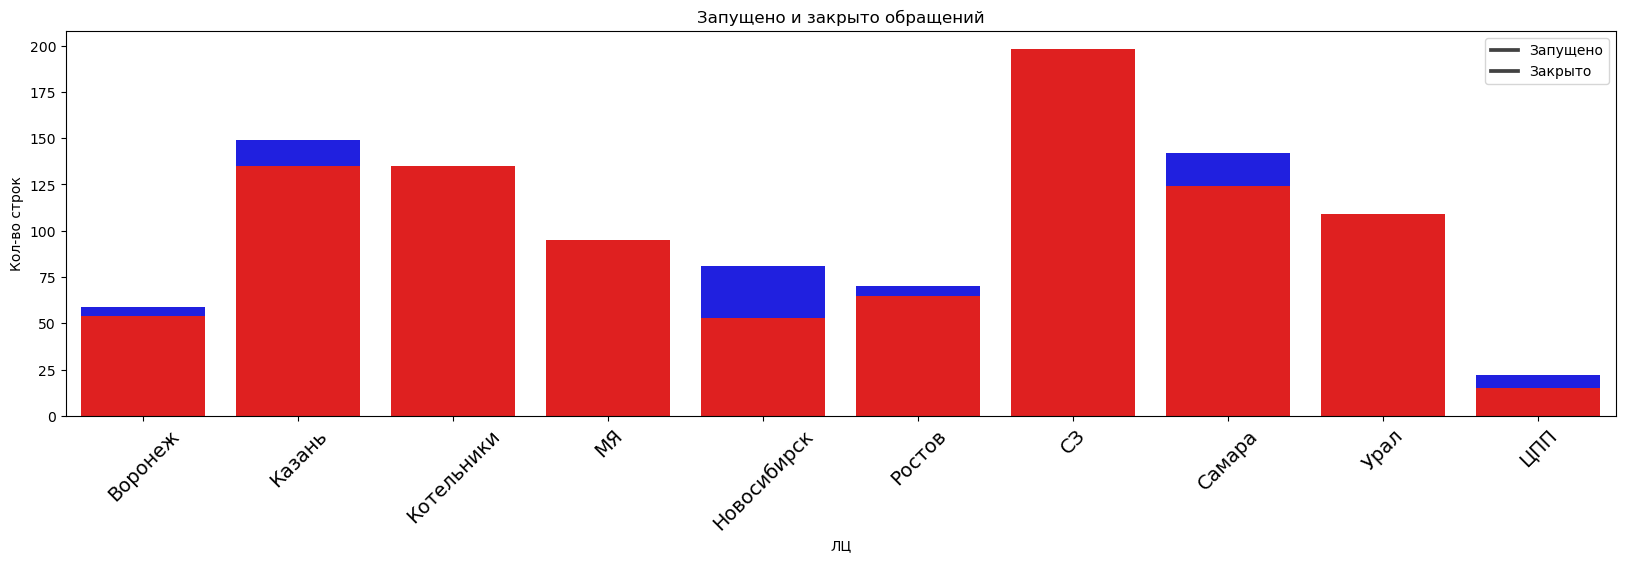

In [37]:
greated_closed_graph = created_closed_yesterday.reset_index()

plt.figure(figsize=(20,5))

ax = sn.barplot(data=greated_closed_graph, x='ЛЦ', y=f"Запущено обращений {yesterday}", color='blue')
sn.barplot(data=greated_closed_graph, x='ЛЦ', y=f"Закрыто обращений {yesterday}", color='red')
plt.xticks(rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title('Запущено и закрыто обращений')
plt.xlabel('ЛЦ')
plt.ylabel('Кол-во строк')
plt.legend(['Запущено', 'Закрыто'])
plt.show()


 Наличие  синего цвета в столбцах графика указывает на то, что было запущено больше обращений чем закрыто.

In [38]:
print(f"Всего запущено рекламаций за {yesterday}: {created_closed_yesterday.reset_index().sum()[column_open]} ")
print(f"Всего закрыто орекламаций за {yesterday}: {created_closed_yesterday.reset_index().sum()[column_closed ]} ")
print(f"Коэффециент отработки рекламаций по сети за  {yesterday}: {round(created_closed_yesterday.reset_index().sum()[column_closed ] / created_closed_yesterday.reset_index().sum()[column_open], 2)} ")
print(f"Всего запущено обращений за {yesterday}: {merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_open_nonmarketable]} ")
print(f"Всего закрыто обращений за {yesterday}: {merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_closed_nonmarketable]} ")
print(f"Коэффециент отработки нетоварных обращений по сети за  {yesterday}: {round(merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_closed_nonmarketable]/merged_non_marketable_familiarize_yesterday.reset_index().sum()[column_open_nonmarketable], 2)} ")

Всего запущено рекламаций за 2023-11-07: 995 
Всего закрыто орекламаций за 2023-11-07: 983 
Коэффециент отработки рекламаций по сети за  2023-11-07: 0.99 
Всего запущено обращений за 2023-11-07: 69 
Всего закрыто обращений за 2023-11-07: 67 
Коэффециент отработки нетоварных обращений по сети за  2023-11-07: 0.97 
